In [1]:
%matplotlib notebook

In [2]:
import gym
from gym.envs.registration import register
import matplotlib as mpl
# mpl.use('agg')
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from tiles3 import IHT, tiles
register(
    id='MountainCar-v1',
    entry_point='gym.envs.classic_control:MountainCarEnv',
    max_episode_steps=5000,
    reward_threshold=-110.0,
)

In [3]:
env = gym.make('MountainCar-v1')
nA = 3
iht = IHT(4096)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [4]:
def _greedy(Q,s):
    qmax = np.max(Q(s))
    actions = []
    for i,q in enumerate(Q(s)):
        if q == qmax:
            actions.append(i)
    return actions

def greedy(Q,s):
    return np.random.choice(_greedy(Q,s))

def ep_greedy(Q,s,ep):
    if np.random.rand() < ep:
        return np.random.choice(len(Q(s)))
    else:
        return greedy(Q,s)
    
def qhat(params,default=0):
    # Estimate the action values using linear approximation.
    def qhatw(s):
        q = []
        for a in range(nA):
            qa = 0
            # Sum of params at active features is the action value.
            for i in feature(s,a):
                qa += params.setdefault(i,default)
                if np.isnan(qa):
                    print(s,a,params.setdefault(i,default))
                    raise ValueError('q is nan')
            q.append(qa)
        return q
    return qhatw

def feature(state,action):
    # Return the indices of active features for state,action pair.
    # Use the tile-coding according to p246 of Sutton's book.
    x,xdot = state
    return tiles(iht,8,[8*x/(0.5+1.2),8*xdot/(0.07+0.07)],[action])

# This algorithm is implemented according to the pseudo-code on p305 of Sutton's book. 
def sarsalambda(env,feature,qhat,epsilon,alpha,lambda_,gamma,n_ep):
    w = {}
    episode = 0
    steps_list = []
    avg_steps = 0
    while episode < n_ep:
        s = env.reset()
        a = ep_greedy(qhat(w),s,epsilon)
        done = False
        steps = 0
        z = {}
        while not done:
#             env.render()
            ss,r,done,_ = env.step(a)
            steps += 1
            delta = r
            for i in feature(s,a):
                delta = delta - w.setdefault(i,0)
                z[i] = z.setdefault(i,0) + 1 # accumulating traces
#                 z[i] = 1 # replacing traces
                if np.isnan(delta):
                    print(steps,w[i])
                    raise ValueError('nan in delta')
            if done:
                for key,val in z.items():
                    w[key] = w.setdefault(key,0) + alpha * delta * val
                    if np.isnan(w[key]):
                        print(steps,w[key])
                        raise ValueError('nan in delta')
                break
            aa = ep_greedy(qhat(w),ss,epsilon)
            for i in feature(ss,aa):
                delta = delta + gamma * w.setdefault(i,0)
                if np.isnan(delta):
                    print(steps,w[i])
                    raise ValueError('nan in delta')
            for key,val in z.items():
                w[key] = w.setdefault(key,0) + alpha * delta * val
                z[key] = gamma * lambda_ * val
            s,a = ss,aa
        episode += 1
        steps_list.append(steps)
        avg_steps = (avg_steps * (episode - 1) + steps) / episode
#         env.render()
    return avg_steps,steps_list

In [10]:
def plot_mountaincar():
    alpha = 0.05
    epsilon = 0
    lambda_ = 0.92
    gamma = 1
    runs = 1
    n_ep = 50
    for run in range(runs):
        avg_steps,steps_list = sarsalambda(env,feature,qhat,epsilon,alpha,lambda_,gamma,n_ep)
        print(avg_steps)
        fig = plt.figure()
        plt.plot(steps_list)
        plt.show()

204.92


<IPython.core.display.Javascript object>


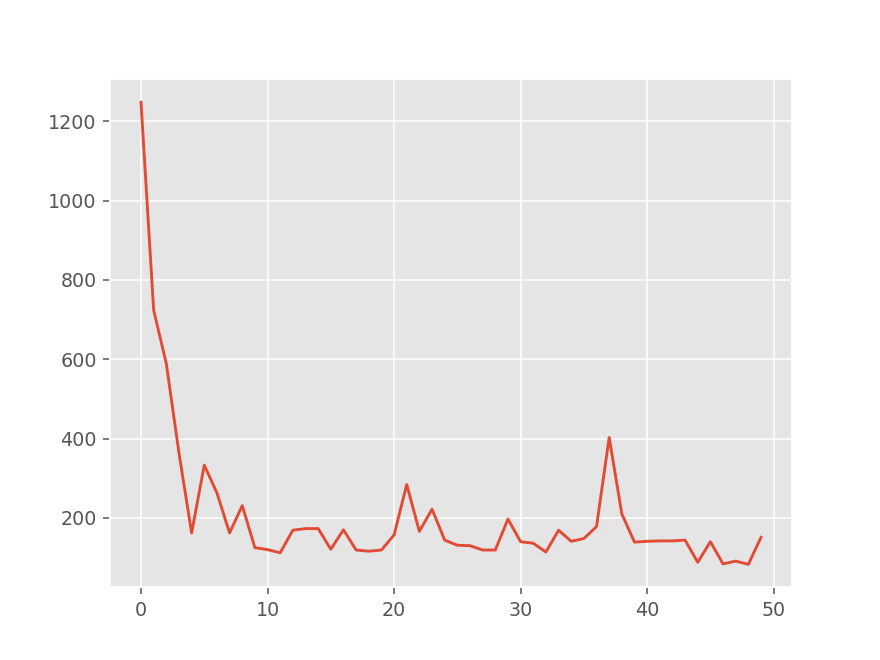

In [12]:
plot_mountaincar()